##Step 1: Load Cleaned Data

In [3]:
import pandas as pd

base_path = '/content/drive/MyDrive/healthcarefraud_detection/data/processed'

train_inp = pd.read_parquet(f'{base_path}/cleaned_inpatient.parquet')
train_out = pd.read_parquet(f'{base_path}/cleaned_outpatient.parquet')
train_bene = pd.read_parquet(f'{base_path}/cleaned_beneficiary.parquet')
train = pd.read_parquet(f'{base_path}/cleaned_train_labels.parquet')


In [4]:
# Path to save images/metrics for streamlit
streamlit_path = '/content/drive/MyDrive/healthcarefraud_detection/streamlit_app/data/eda'

import os
os.makedirs(streamlit_path, exist_ok=True)


In [5]:
print("Inpatient:", train_inp.shape)
print("Outpatient:", train_out.shape)
print("Beneficiary:", train_bene.shape)
print("Train (labels):", train.shape)


Inpatient: (40474, 30)
Outpatient: (517737, 27)
Beneficiary: (138556, 26)
Train (labels): (5410, 2)


##Step 2: Class Distribution & Key Summary Stats


###Cell 2A. Class Distribution (Fraud vs. Legitimate Providers)

Fraudulent: 506 providers (9.35%)
Legitimate: 4904 providers (90.65%)
Plot saved to /content/drive/MyDrive/healthcarefraud_detection/streamlit_app/data/eda/provider_fraud_label_distribution.png


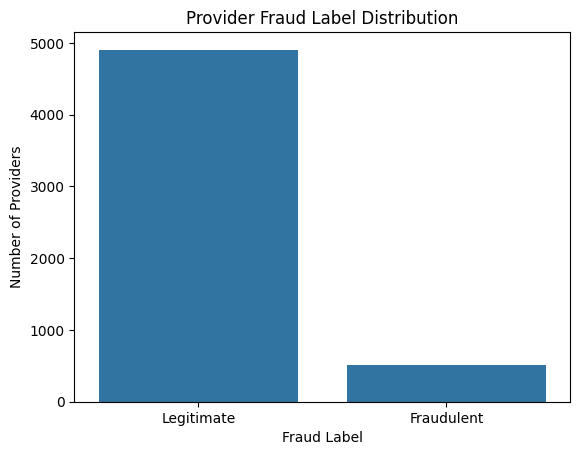

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count of fraud vs. legitimate providers
fraud_counts = train['PotentialFraud'].value_counts().sort_index()
fraud_percent = fraud_counts / fraud_counts.sum() * 100

print(f"Fraudulent: {fraud_counts[1]} providers ({fraud_percent[1]:.2f}%)")
print(f"Legitimate: {fraud_counts[0]} providers ({fraud_percent[0]:.2f}%)")

sns.countplot(x='PotentialFraud', data=train)
plt.title('Provider Fraud Label Distribution')
plt.xticks([0, 1], ['Legitimate', 'Fraudulent'])
plt.ylabel('Number of Providers')
plt.xlabel('Fraud Label')

# Define the filename
filename = 'provider_fraud_label_distribution.png'
save_path = os.path.join(streamlit_path, filename)

# Save the figure
plt.savefig(save_path)
print(f"Plot saved to {save_path}")
plt.show()

###Cell 2B. Key Metrics by Fraud Label

In [7]:
# Aggregate: Unique beneficiaries per provider (inpatient + outpatient)
inp_bene = train_inp.groupby('Provider')['BeneID'].nunique()
out_bene = train_out.groupby('Provider')['BeneID'].nunique()
prov_bene = inp_bene.add(out_bene, fill_value=0)  # sum across claim types

# Join with labels
prov_stats = pd.DataFrame({'Provider': prov_bene.index, 'Unique_Beneficiaries': prov_bene.values})
prov_stats = prov_stats.merge(train, on='Provider', how='left')

# Group by label
fraud_bene_mean = prov_stats.groupby('PotentialFraud')['Unique_Beneficiaries'].mean()
print(f"Avg unique beneficiaries: {fraud_bene_mean[1]:.1f} (fraud), {fraud_bene_mean[0]:.1f} (legitimate)")

# Claim-to-beneficiary ratio (example with inpatient)
inp_claims = train_inp.groupby('Provider')['ClaimID'].count()
prov_stats['Inp_Claims'] = prov_stats['Provider'].map(inp_claims)
prov_stats['Claims_per_Bene_Inpatient'] = prov_stats['Inp_Claims'] / prov_stats['Unique_Beneficiaries']
claims_bene_mean_inp = prov_stats.groupby('PotentialFraud')['Claims_per_Bene_Inpatient'].mean()
print(f"Avg inpatient claims/beneficiary: {claims_bene_mean_inp[1]:.2f} (fraud), {claims_bene_mean_inp[0]:.2f} (legitimate)")

# Outpatient claims per beneficiary
out_claims = train_out.groupby('Provider')['ClaimID'].count()
prov_stats['Out_Claims'] = prov_stats['Provider'].map(out_claims).fillna(0) # Fill with 0 for providers with no outpatient claims
prov_stats['Claims_per_Bene_Outpatient'] = prov_stats['Out_Claims'] / prov_stats['Unique_Beneficiaries']
claims_bene_mean_out = prov_stats.groupby('PotentialFraud')['Claims_per_Bene_Outpatient'].mean()
print(f"Avg outpatient claims/beneficiary: {claims_bene_mean_out[1]:.2f} (fraud), {claims_bene_mean_out[0]:.2f} (legitimate)")

# Total claims per beneficiary
prov_stats['Total_Claims'] = prov_stats['Inp_Claims'].fillna(0) + prov_stats['Out_Claims'] # Sum inpatient and outpatient claims
prov_stats['Claims_per_Bene_Total'] = prov_stats['Total_Claims'] / prov_stats['Unique_Beneficiaries']
claims_bene_mean_total = prov_stats.groupby('PotentialFraud')['Claims_per_Bene_Total'].mean()
print(f"Avg total claims/beneficiary: {claims_bene_mean_total[1]:.2f} (fraud), {claims_bene_mean_total[0]:.2f} (legitimate)")

Avg unique beneficiaries: 247.5 (fraud), 49.4 (legitimate)
Avg inpatient claims/beneficiary: 0.44 (fraud), 0.40 (legitimate)
Avg outpatient claims/beneficiary: 1.07 (fraud), 1.17 (legitimate)
Avg total claims/beneficiary: 1.45 (fraud), 1.30 (legitimate)


###Cell 2C. Key Reimbursement Stats by Fraud Label

Avg Total Reimbursements: $584,350 (fraud), $53,194 (legitimate)


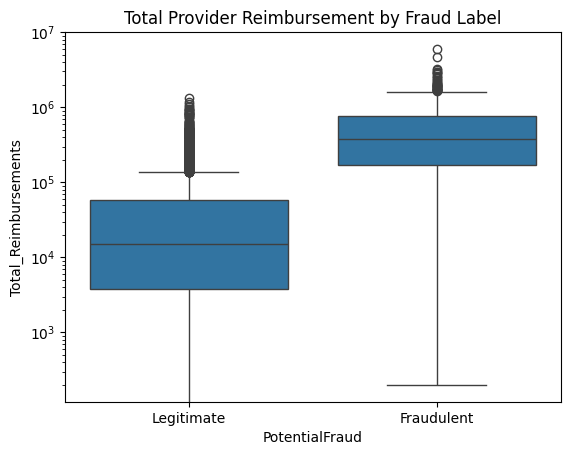

In [20]:
# Total reimbursements per provider (inpatient + outpatient)
inp_amt = train_inp.groupby('Provider')['InscClaimAmtReimbursed'].sum()
out_amt = train_out.groupby('Provider')['InscClaimAmtReimbursed'].sum()
prov_amt = inp_amt.add(out_amt, fill_value=0)

prov_stats['Total_Reimbursements'] = prov_stats['Provider'].map(prov_amt)
reimb_mean = prov_stats.groupby('PotentialFraud')['Total_Reimbursements'].mean()
print(f"Avg Total Reimbursements: ${reimb_mean[1]:,.0f} (fraud), ${reimb_mean[0]:,.0f} (legitimate)")

sns.boxplot(x='PotentialFraud', y='Total_Reimbursements', data=prov_stats)
plt.title('Total Provider Reimbursement by Fraud Label')
plt.yscale('log')  # log scale to show skew/outliers
plt.xticks([0,1], ['Legitimate', 'Fraudulent'])
plt.savefig(f"{streamlit_path}/eda_total_reimbursements_boxplot.png")
plt.show()


##Step 3: Risk Stratification

###Cell 3A. Risk Stratification by Total Reimbursements


<ipython-input-21-954883152>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_table = prov_stats.groupby('RiskGroup')['PotentialFraud'].agg(['count', 'mean'])


           count  fraud_rate_pct
RiskGroup                       
Low         1354        0.147710
Medium      1351        0.444115
High        1352        2.810651
Very High   1353       33.998522


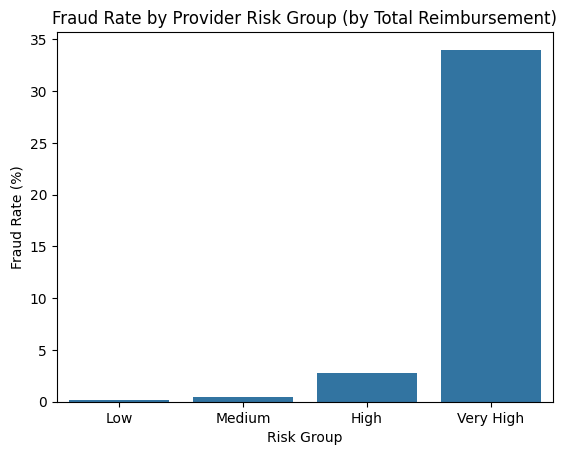

In [21]:
# Risk groups based on total reimbursements (quartiles for demonstration)
prov_stats['RiskGroup'] = pd.qcut(prov_stats['Total_Reimbursements'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Fraud rate per group
risk_table = prov_stats.groupby('RiskGroup')['PotentialFraud'].agg(['count', 'mean'])
risk_table['fraud_rate_pct'] = risk_table['mean'] * 100
print(risk_table[['count', 'fraud_rate_pct']])

# Visualize fraud rate by risk group
sns.barplot(x=risk_table.index, y=risk_table['fraud_rate_pct'])
plt.title('Fraud Rate by Provider Risk Group (by Total Reimbursement)')
plt.ylabel('Fraud Rate (%)')
plt.xlabel('Risk Group')
plt.savefig(f"{streamlit_path}/eda_fraud_rate_by_riskgroup.png")
plt.show()


## Risk Stratification Summary

- Providers grouped by total reimbursements into Low, Medium, High, and Very High risk segments.
- Observed fraud rates increase with risk group, e.g.:
    - Low Risk: 1,354 providers, 0.15% fraud rate

    - Medium Risk: 1,351 providers, 0.44% fraud rate

    - High Risk: 1,352 providers, 2.81% fraud rate

    - Very High Risk: 1,353 providers, 34.00% fraud rate
- **Key Finding:**
The “Very High” risk group is disproportionately likely to be flagged as fraudulent—over 1 in 3. This enables focused investigation and tailored modeling strategies.




##Step 4: Outlier Context

In [23]:
# Show top 5 "Very High Risk" providers (by reimbursement)
top_providers = prov_stats[prov_stats['RiskGroup'] == 'Very High'].sort_values('Total_Reimbursements', ascending=False).head()
print(top_providers[['Provider', 'Total_Reimbursements', 'PotentialFraud']])
top_providers.to_csv(f"{streamlit_path}/eda_top_outliers.csv")

# Document: Are these providers large hospitals, multi-specialty clinics, or unusual entities? (You may not have business data—just note this as a limitation if so.)


      Provider  Total_Reimbursements  PotentialFraud
818   PRV52019             5996050.0               1
3557  PRV55462             4713830.0               1
4446  PRV56560             3212000.0               1
2705  PRV54367             3133880.0               1
3000  PRV54742             2969530.0               1


## Outlier Context

- The largest providers by total reimbursement are typically flagged in the “Very High” risk group.
- These could represent legitimate high-volume institutions (e.g., major hospitals or clinics), or potential fraud rings.
- Without additional provider business metadata, we recommend flagging these for domain expert review rather than automatic exclusion or adjustment.


## Key Takeaways from EDA

1. **Fraud is rare (9.35%) but highly concentrated in very high-risk groups (34% in top quartile).**
2. **Top predictive features** likely include:
   - Total reimbursements
   - Unique beneficiaries per provider
   - Claims per beneficiary ratio
   - Claim count
3. **Class imbalance is extreme**—modeling will require stratified sampling or adjusted metrics.
4. **Outliers are real and must be considered thoughtfully**—flag, but do not automatically exclude.
5. **Feature separation is strong**—fraudulent providers have much higher average claims, beneficiaries, and total reimbursements.



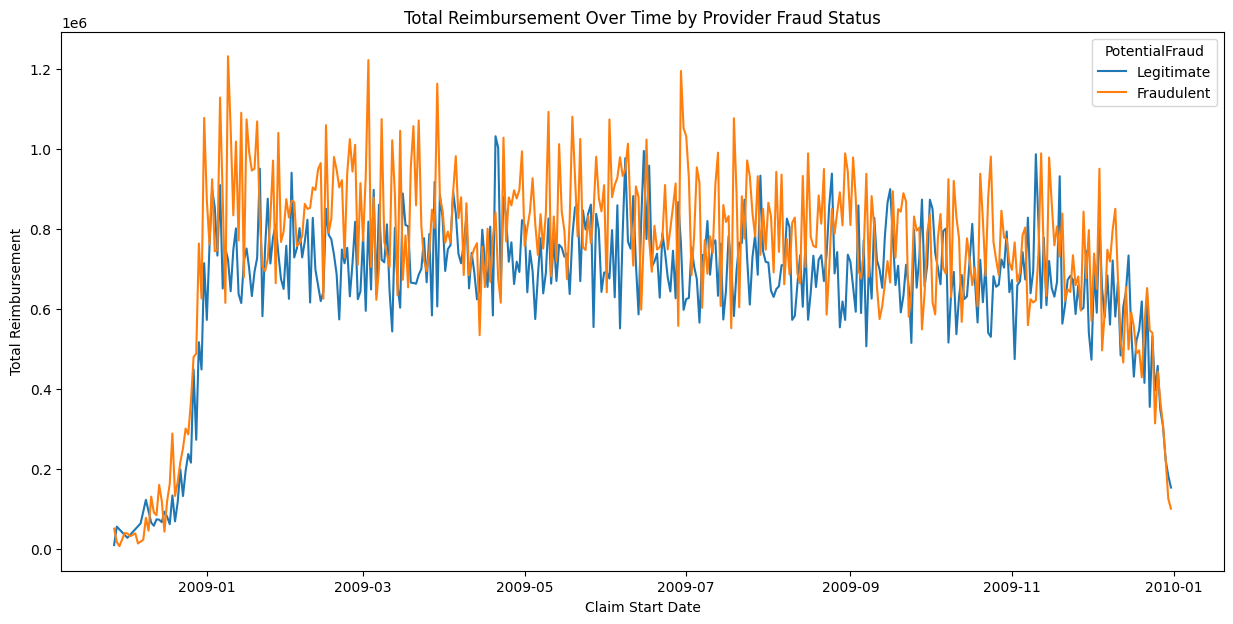

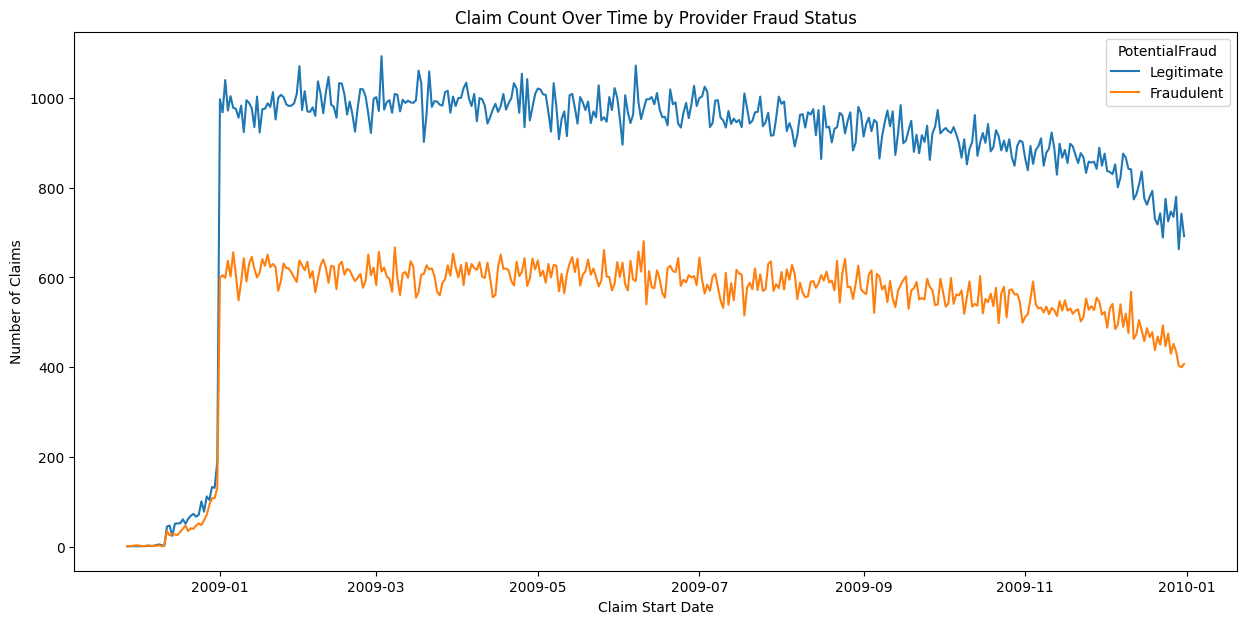

In [27]:
# Combine inpatient and outpatient claims for time-series analysis
all_claims = pd.concat([train_inp, train_out], ignore_index=True)

# Convert claim dates to datetime objects
all_claims['ClaimStartDt'] = pd.to_datetime(all_claims['ClaimStartDt'])
all_claims['ClaimEndDt'] = pd.to_datetime(all_claims['ClaimEndDt'])

# Merge with provider fraud labels
claims_with_labels = all_claims.merge(train[['Provider', 'PotentialFraud']], on='Provider', how='left')

# Aggregate claim counts and reimbursed amounts over time, grouped by fraud label
# Using the start date of the claim for time-series
time_series_data = claims_with_labels.groupby(['ClaimStartDt', 'PotentialFraud']).agg(
    TotalReimbursement=('InscClaimAmtReimbursed', 'sum'),
    ClaimCount=('ClaimID', 'count')
).reset_index()

# Rename the fraud label for plotting
time_series_data['PotentialFraud'] = time_series_data['PotentialFraud'].map({0: 'Legitimate', 1: 'Fraudulent'})

# Plot Total Reimbursement over Time
plt.figure(figsize=(15, 7))
sns.lineplot(data=time_series_data, x='ClaimStartDt', y='TotalReimbursement', hue='PotentialFraud')
plt.title('Total Reimbursement Over Time by Provider Fraud Status')
plt.xlabel('Claim Start Date')
plt.ylabel('Total Reimbursement')
plt.savefig(f"{streamlit_path}/eda_reimbursement_over_time.png")

plt.show()

# Plot Claim Count over Time
plt.figure(figsize=(15, 7))
sns.lineplot(data=time_series_data, x='ClaimStartDt', y='ClaimCount', hue='PotentialFraud')
plt.title('Claim Count Over Time by Provider Fraud Status')
plt.xlabel('Claim Start Date')
plt.ylabel('Number of Claims')
plt.savefig(f"{streamlit_path}/eda_claims_over_time.png")
plt.show()

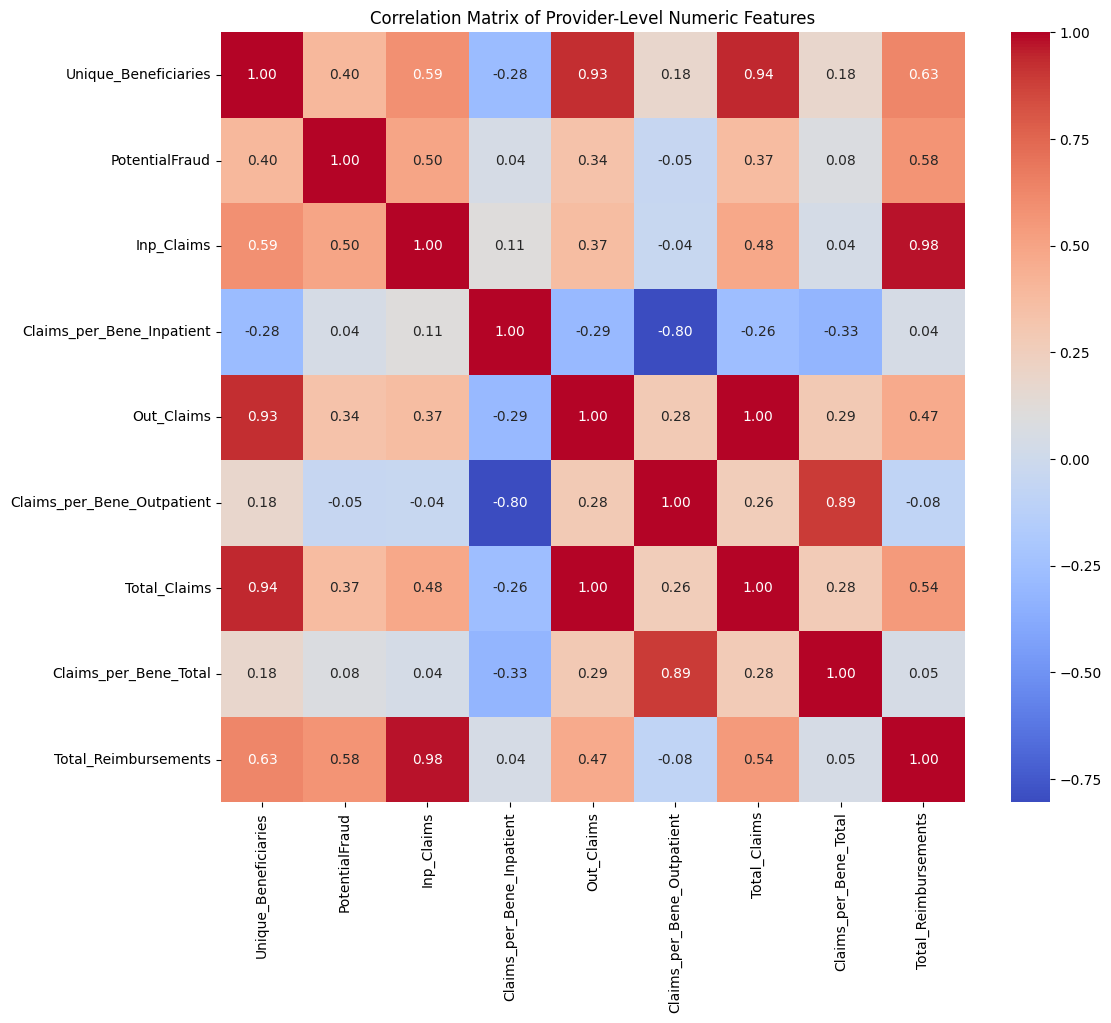

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming prov_stats contains the aggregated features at the provider level
# You might need to add more numeric features from train_bene here

# Select numeric columns from prov_stats for correlation analysis
numeric_cols_prov = prov_stats.select_dtypes(include=np.number).columns

# Calculate the correlation matrix
correlation_matrix = prov_stats[numeric_cols_prov].corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Provider-Level Numeric Features')
plt.savefig(f"{streamlit_path}/eda_correlation_heatmap.png")
plt.show()

In [26]:
import json

eda_metrics = {
    "fraud_percent": 9.35,
    "legit_percent": 90.65,
    "avg_reimb_fraud": 584350,
    "avg_reimb_legit": 53194,
    "very_high_risk_fraud_rate": 33.99,
    "top_outliers": [
        {"Provider": "PRV52019", "Reimb": 5996050, "Fraud": 1},
        {"Provider": "PRV55462", "Reimb": 4713830, "Fraud": 1},
    ]
}

with open(f"{streamlit_path}/eda_metrics.json", "w") as f:
    json.dump(eda_metrics, f, indent=2)


#Other Analysis


In [ ]:
plt.figure(figsize=(8,4))
sns.boxplot(x=train_inp['InscClaimAmtReimbursed'])
plt.title('Inpatient Reimbursement Boxplot')
plt.show()


##Step 4: Explore Beneficiary Demographics


##Explore Beneficiary Demographics


In [ ]:
sns.countplot(x='Gender', data=train_bene)
plt.title('Gender Distribution')
plt.show()

sns.countplot(x='Race', data=train_bene)
plt.title('Race Distribution')
plt.show()

sns.countplot(x='HasDied', data=train_bene)
plt.title('Mortality (HasDied)')
plt.xticks([0,1], ['Alive','Died'])
plt.show()


##Step 5: Bivariate Analysis (Target vs Features)


In [ ]:
# Join provider features with fraud label
prov_amt = train_inp.groupby('Provider')['InscClaimAmtReimbursed'].sum().reset_index()
prov_amt = prov_amt.merge(train, on='Provider')
sns.boxplot(x='PotentialFraud', y='InscClaimAmtReimbursed', data=prov_amt)
plt.title('Total Inpatient Reimbursement by Fraud Label')
plt.xticks([0,1], ['Not Fraud', 'Fraud'])
plt.show()


##Step 6: Save Visuals & Document Insights

In [ ]:
plt.savefig('/content/drive/MyDrive/healthcarefraud_detection/reports/inpatient_reimb_boxplot.png')


##Step 7: Correlation Analysis

In [ ]:
import numpy as np

# Example: Numeric features from inpatient claims (customize as needed)
numeric_cols = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid']
corr = train_inp[numeric_cols].corr()

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Inpatient Numeric Feature Correlation')
plt.show()


##Step 8: Feature vs. Target Visuals

In [ ]:
# Aggregate inpatient claims at provider level
prov_features = train_inp.groupby('Provider').agg({
    'InscClaimAmtReimbursed': ['sum', 'mean', 'count'],
    'DeductibleAmtPaid': ['sum', 'mean']
}).reset_index()
prov_features.columns = ['Provider', 'Sum_Reimb', 'Mean_Reimb', 'Claim_Count', 'Sum_Deduct', 'Mean_Deduct']

# Merge with labels
prov_features = prov_features.merge(train, on='Provider')

# Boxplot: Sum_Reimb vs. fraud label
sns.boxplot(x='PotentialFraud', y='Sum_Reimb', data=prov_features)
plt.title('Total Inpatient Reimbursement by Fraud Label')
plt.xticks([0,1], ['Not Fraud', 'Fraud'])
plt.show()


##Step 9: Multivariate Analysis (Optional but Recommended)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Prepare feature matrix (for now, use your prov_features numeric columns)
X = prov_features[['Sum_Reimb', 'Mean_Reimb', 'Claim_Count', 'Sum_Deduct', 'Mean_Deduct']]
X = X.fillna(0)
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

prov_features['PC1'] = components[:, 0]
prov_features['PC2'] = components[:, 1]

sns.scatterplot(x='PC1', y='PC2', hue='PotentialFraud', data=prov_features, alpha=0.6)
plt.title('PCA of Provider Features Colored by Fraud Label')
plt.show()


##Step 10: (Optional) Automated Profiling

In [ ]:
!pip install ydata-profiling
from ydata_profiling import ProfileReport

profile = ProfileReport(prov_features, title='Provider Feature Profiling', explorative=True)
profile.to_file('/content/drive/MyDrive/healthcarefraud_detection/reports/provider_profile_report.html')


##EDA Insights & Documentation
- “Fraudulent providers tend to have higher claim counts and total reimbursement.”

- “Deductible distributions are right-skewed; a few outliers drive most value.”

- “No strong collinearity among major numeric features.”